In [1]:
from datetime import datetime
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn import metrics
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Fill in Parameters here
#### Reminder to set the radius before running the code
#### Note: The radius here needs to match the radius set in the "2_data_processing_data_visualization" notebook

In [2]:
radius = 200 # <== Set Radius before running 
tuned_parameters = [{'n_neighbors': list(range(2,30,2)),
                    "weights":['uniform'],
                    'p' : [2]}]
scoring_parameter = "accuracy"

# Extract Data

In [3]:
### Extract 
data_df_extract = pd.read_csv("data_transformed.csv")
data_df_original = data_df_extract.copy()
data_df_original.head()

,time,latitude,longitude,depth,mag,Nearest City,Distance,label
0,2022-04-18,36.9462,140.3737,94.06,5.3,Tokyo,152.519581,True
1,2022-04-18,29.7594,142.1689,10.00,4.9,>200 KM of Nearest City,698.847508,True
2,2022-04-17,37.7504,141.7200,55.40,4.5,Sendai,94.259210,False
3,2022-04-17,31.1878,142.4014,10.00,4.5,>200 KM of Nearest City,560.090362,False
4,2022-04-17,37.0863,142.1903,30.46,4.4,Sendai,175.485563,False


# Train and Predict the Model and output Results for all the City overall

Fitting 5 folds for each of 14 candidates, totalling 70 fits
KNeighborsClassifier(n_neighbors=28)
{'n_neighbors': 28, 'p': 2, 'weights': 'uniform'}


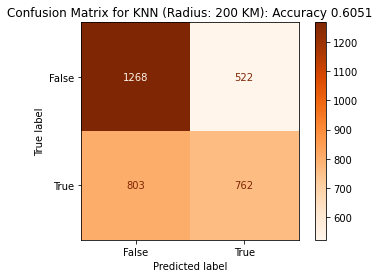

validation accuracy: 0.6050670640834576
True Positive = 762
False Positive = 522
False Negative = 803
True Negative = 1268
Recall = 49.0
Precision = 59.0


In [4]:
# Extract only the datapoints that are within a radius of any of the main cities
data_df = data_df_original.drop(data_df_original[data_df_original["Nearest City"]==f">{radius} KM of Nearest City"].index)
data_df.reset_index(drop=True, inplace=True)

# Extract key attributes for training and predicting
data_df = data_df.drop(columns = ['time',"Nearest City","mag","Distance"] )

# Extract Training and Testing Dataset
X = data_df.drop(["label"], axis=1)
y = data_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

# Train the Model
clf_model_knn = GridSearchCV(KNeighborsClassifier(),
                                      tuned_parameters,
                                      cv=5,
                                      scoring=scoring_parameter,
                                      verbose=1)
clf_model_knn.fit(X_train.values, y_train.values)

# Validate with Testing dataset
predict_y_test = clf_model_knn.predict(X_test.values)
accuracy_score_results = accuracy_score(y_test.values, predict_y_test)


#########################################
### Display Confusion Matrix
print(clf_model_knn.best_estimator_)
print(clf_model_knn.best_params_)
ConfusionMatrixDisplay.from_predictions(y_test.values, predict_y_test, cmap='Oranges')
plt.title("""Confusion Matrix for KNN (Radius: {} KM): Accuracy {:.4}""".format(radius, accuracy_score_results),color='black')
plt.show()

TN, FP, FN, TP = confusion_matrix(y_test.values, predict_y_test).ravel()

print("validation accuracy:", accuracy_score_results)
print('True Positive = {}'.format(TP))
print('False Positive = {}'.format(FP))
print('False Negative = {}'.format(FN))
print('True Negative = {}'.format(TN))
print('Recall = {}'.format(100*round(TP/(TP+FN),2)))
print('Precision = {}'.format(100*round(TP/(TP+FP),2)))

# Print the ROC Curve Plot

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


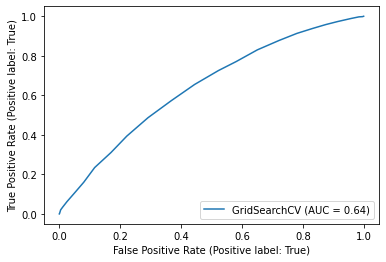

In [5]:
metrics.plot_roc_curve(clf_model_knn, X_test.values, y_test.values) 

# Print the Accuracy vs K Value Plot

In [6]:
# Extract the Dataset again
data_df_extract = pd.read_csv("data_transformed.csv")
data_df_plot_curve = data_df_extract.copy()

In [7]:
# Extract only the datapoints that are within a radius of any of the main cities
data_df = data_df_plot_curve.drop(data_df_plot_curve[data_df_plot_curve["Nearest City"]==f">{radius} KM of Nearest City"].index)
data_df.reset_index(drop=True, inplace=True)

# Extract key attributes for training and predicting
data_df = data_df.drop(columns = ['time',"Nearest City","mag","Distance"] )

# Extract Training and Testing Dataset
X = data_df.drop(["label"], axis=1)
y = data_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

# make a list of k values
k_value_list = list(range(2,30,2))

accuracy_score_list = []
recall_list = []
precision_list = []
for k_value in k_value_list:
    # Train Model 
    clf_model_knn_plot = KNeighborsClassifier(n_neighbors=k_value,weights = "uniform", p=1)
    clf_model_knn_plot.fit(X_train.values, y_train.values)
    
    # Predict using testing dataset
    predict_y_test = clf_model_knn_plot.predict(X_test.values)
    
    # extract the metrics results and store in list
    accuracy_score_results = accuracy_score(y_test.values, predict_y_test)
    TN, FP, FN, TP = confusion_matrix(y_test.values, predict_y_test).ravel()
    recall = 100*round(TP/(TP+FN),2)
    precision = 100*round(TP/(TP+FP),2)
    # store in list
    accuracy_score_list.append(accuracy_score_results)
    recall_list.append(recall)
    precision_list.append(precision)

# Convert list into dataframe for plotting
data_metric = {"k":k_value_list, "recall":recall_list, "precision":precision_list, "accuracy":accuracy_score_list}
df_metric = pd.DataFrame(data_metric)

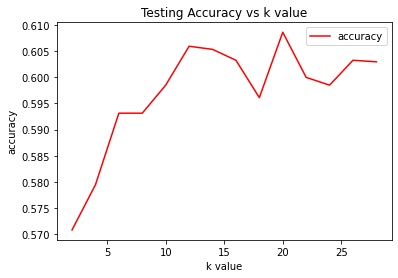

In [8]:
# Plot the Accuracy vs K value
df_metric.plot(kind='line',x='k',y='accuracy',color='red',
               title="Testing Accuracy vs k value",xlabel="k value", ylabel="accuracy")
plt.show()